# Machine Learning

*Екатерина Лобачева / Илья Щуров / Сергей Сметанин *

*Совместный бакалавриат НИУ ВШЭ и РЭШ, 2016-17 учебный год*

[Страница курса](http://math-info.hse.ru/2016-17/Machine_Learning)

### Семинар 4: Нейросети

Сгенерируем немножко данных. (На семинаре мы загружали эти данные из csv-файла с помощью `pandas`.)

In [1]:
import numpy as np
import scipy

np.random.seed(42)
scipy.random.seed(42)
# для воспроизводимости

S = np.array([[2, 3], [3, 2]])
# некоторая матрица

data_points = 300
data_init = [([-4, 4], np.eye(2), data_points, 1),
            ([4, -4], np.eye(2), data_points, 1),
            ([0, 0], S.T @ S, data_points, 0)]

# data_init содержат наборы: (центр, матрица ковариации, число точек, класс)

X = np.vstack([np.random.multivariate_normal(m, c, n) 
               for m, c, n, _ in data_init])

# .vstack соединяет массивы «по вертикали»

y = np.array([class_ for _, _, n, class_ in data_init 
              for i in range(n)]).reshape(-1, 1)
# нам нужно сделать .reshape(-1, 1), чтобы получился вектор-столбец
# мы ставим -1 напротив той оси, которая заполняется автоматически
# в данном случае мы говорим, что нужно сделать из y матрицу
# с одним столбцом и каким-то количеством строчек

Посмотрим, что получилось.

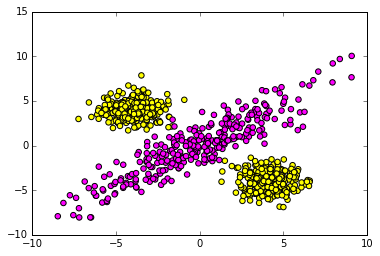

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:, 0], X[:, 1], 30, y, cmap='spring')

Два кластера по краям относятся к одному классу, а вытянутый кластер посередине — к другому. Разделение их с помощью линейной регрессии (без использования каких-нибудь дополнительных координат) невозможно, поскольку нет прямой, которая бы разделяла эти классы. Поэтому мы попробуем использовать нейросеть.

Для начала подготовим данные. Для этого нам понадобится объект `pybrain.datasets.ClassificationDataSet`, используемый в задачах классификации. Сделаем вспомогательную функцию, которая наполняет датасет, получив на вход матрицы входных и выходных значений. 

In [3]:
from pybrain.datasets import ClassificationDataSet

def buildDataSet(x_data, y_data):
    data = ClassificationDataSet(x_data.shape[1], y_data.shape[1])
    # создали пустой набор данных, размерность входных данных равна 
    # числу столбцов в x_data, а выходных — числу столбцов в y_data
    
    for x, y in zip(x_data, y_data):
        data.addSample(x, y)
        # добавили очередную строчку
    return data

Разделим наши данные на обучающую и тестовую выборки с помощью sklearn и сделаем из них датасеты для *pybrain*.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
train = buildDataSet(X_train, y_train)
test = buildDataSet(X_test, y_test)

Посмотрим, что получилось:

In [5]:
train.getFieldNames()

['target', 'class', 'input']

In [6]:
train['target'][:5]

array([[1],
       [1],
       [0],
       [0],
       [0]])

Нам хочется преобразовать выход таким образом, чтобы каждому классу соответствовал свой столбец (нейросети так лучше обучаются). То есть мы хотим превратить `[0]` в `[1, 0]` и `[1]` в `[0, 1]`. Для этого можно использовать такой метод:

In [7]:
train._convertToOneOfMany()
test._convertToOneOfMany()
# вообще-то лучше не пользоваться методами, которые начинаются с 
# нижнего подчёркивания — они могут изменяться без предупреждения
# но мы пока воспользуемся

In [8]:
train['target']

array([[0, 1],
       [0, 1],
       [1, 0],
       ..., 
       [1, 0],
       [1, 0],
       [0, 1]], dtype=int32)

Теперь создадим нейросеть. Библиотека *pybrain* позволяет создавать достаточно сложные нейросети с различным числом слоёв и хитро устроенными связями между ними. Но мы хотим использовать простейшую сеть с одним скрытым слоем и поэтому воспользуемся готовой функцией `pybrain.tools.shortcuts.buildNetwork`. Впрочем, нам понадобится ей указать, какие активирующие функции мы хотим использовать: а именно, для среднего слоя нейронов мы хотим использовать гиперболический тангенс, а для вычисления итоговых вероятностей — softmax. Чтобы это сделать, нам нужно загрузить соответствующие объекты. 

In [9]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure import TanhLayer, SoftmaxLayer

input_neurons = 2
output_neurons = 2
hidden_neurons = 1

network = buildNetwork(input_neurons, hidden_neurons, output_neurons, 
                       hiddenclass=TanhLayer, outclass=SoftmaxLayer)

Количество нейронов на входном и выходном слоях определяется размерностью соответствующих пространств. В данном случае у нас два признака (у матрицы $X$ два столбцы) и двумерное пространство ответом (после преобразования пространства ответов), поэтому этих нейронов обязательно должно быть по два. Число нейронов в скрытом слое может отличаться. Возьмём для начала один нейрон.

Посмотрим, как устроена наша нейросеть.

In [10]:
network.modules

{<BiasUnit 'bias'>,
 <TanhLayer 'hidden0'>,
 <SoftmaxLayer 'out'>,
 <LinearLayer 'in'>}

`BiasUnit` — это «единичный» нейрон, который нужно добавить к каждому слою (он выполняет функцию *intercept*'а в регрессиях).

In [11]:
network.connections

{<BiasUnit 'bias'>: [<FullConnection 'FullConnection-4': 'bias' -> 'out'>,
  <FullConnection 'FullConnection-5': 'bias' -> 'hidden0'>],
 <TanhLayer 'hidden0'>: [<FullConnection 'FullConnection-6': 'hidden0' -> 'out'>],
 <SoftmaxLayer 'out'>: [],
 <LinearLayer 'in'>: [<FullConnection 'FullConnection-7': 'in' -> 'hidden0'>]}

Выглядит вроде как надо.

Нам теперь потребуется создать `trainer` — объект, который и будет обучаться.

In [12]:
from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(network, train, weightdecay=0.00001)
# weightdecay — это параметр регуляризации

Всё готово к тому, чтобы обучить нашу первую нейросеть. Приготовьтесь к столкновению с искусственым разумом! :)

In [13]:
trainer.trainEpochs(100)

Предыдущая ячейка выполнялась существенное время. Это потому что *pybrain* по умолчанию использует алгоритмы, написанные на чистом Python, и поэтому довольно медленные. Посмотрим, что получилось. Теперь у нас есть обученная сеть. Чтобы скормить ей какие-нибудь входные данные и получить ответ, нужно использовать метод `activate()`.

In [14]:
trainer.module.activate([1, 2])

array([ 0.50870526,  0.49129474])

Ответ следует интерпретировать так: нейросеть полагает, что точка $(1, 2)$ принадлежит классу 0 с вероятностью, равной первому числу в массиве, и к классу 1 с вероятностью, равной второму числу в массиве. (Можно проверить, что их сумма равна 1, спасибо softmax.)

Посмотрим, что получается на тестовой выборке.

In [15]:
result_on_test = trainer.module.activateOnDataset(test)
result_on_test[:5]

array([[ 0.00121488,  0.99878512],
       [ 0.50870558,  0.49129442],
       [ 0.00124065,  0.99875935],
       [ 0.5087157 ,  0.4912843 ],
       [ 0.50868273,  0.49131727]])

Здесь указаны вероятности, а мы бы хотели получить однозначное предсказание, какой объект в какой класс записывать. Для этого найдём в каждой строчке максимум и определим, какой у него индекс. Это и будет номер класса.

In [16]:
classes_predicted = np.argmax(result_on_test, axis=1)
classes_predicted

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

Функция `np.argmax` вычисляет индекс максимального элемента; как и многие другие функции `numpy` она умеет работать с двумерными массивами по строкам или столбцам; в данном случае мы попросили работать по строкам (`axis=1`).

In [17]:
from pybrain.utilities import percentError
percentError(classes_predicted, y_test)

34.22222222222222

Да-а, 65% угадываний — не слишком впечатляет! Что случилось? Посмотрим на картинке.

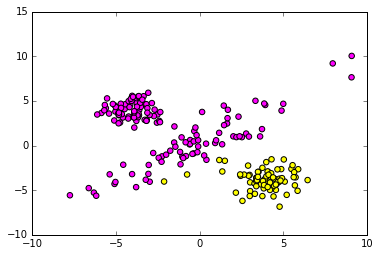

In [18]:
plt.scatter(X_test[:, 0], X_test[:, 1], 30, classes_predicted, cmap='spring')

Ничего удивительного! Мы использовали лишь один нейрон! С одним нейроном много не надумаешь: наша нейросеть ведёт себя примерно так же, как логистическая регрессия (только сглаживающая функция немного другая) — пытается отделить один кластер от другого прямой линией — и, конечно, терпит сокрушительное фиаско. Посмотрим, что будет для большего количества нейронов.

In [19]:
def train_n_show(hidden_neurons=1):
    input_neurons = 2
    output_neurons = 2

    network = buildNetwork(input_neurons, hidden_neurons, output_neurons, 
                           hiddenclass=TanhLayer, outclass=SoftmaxLayer)
    trainer = BackpropTrainer(network, train, weightdecay=0.00001)
    print("Training network with {} hidden neurons".format(hidden_neurons))
    trainer.trainEpochs(100)
    result_on_test = trainer.module.activateOnDataset(test)
    classes_predicted = np.argmax(result_on_test, axis=1)
    print("Percent of errors:", percentError(classes_predicted, y_test))
    plt.scatter(X_test[:, 0], X_test[:, 1], 30, classes_predicted, cmap='spring')    
    return trainer

Training network with 2 hidden neurons
Percent of errors: 18.22222222222222


<BackpropTrainer 'BackpropTrainer-18'>

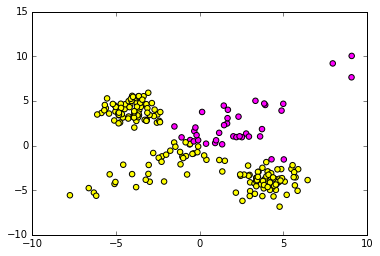

In [20]:
train_n_show(2)

Не очень.

Training network with 5 hidden neurons
Percent of errors: 1.3333333333333333


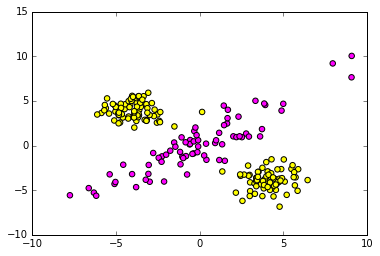

In [21]:
trainer = train_n_show(5)

А пяти нейронов вроде бы уже хватило!

Посмотрим, как выглядят классы во всём пространстве признаков с точки зрения нашей нейросети. И как границы между классами соотносятся с нашей выборкой.

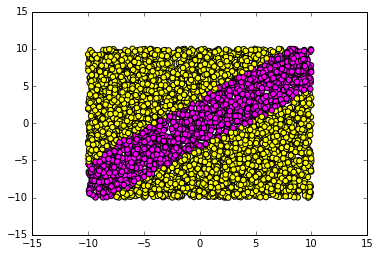

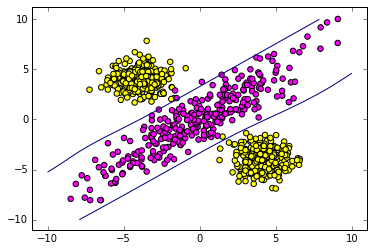

In [22]:
def show_borders(trainer):
    new_test_n = 5000
    # создадим 5000 тестовых точек, равномерно распределённых в квадрате
    new_test_X = np.random.uniform(-10, 10, size=(new_test_n, 2))
    new_test_y = np.array([0] * new_test_n).reshape(-1, 1)
    # нам сейчас не важен ответ

    new_test = buildDataSet(new_test_X, new_test_y)

    result_on_test = trainer.module.activateOnDataset(new_test)
    classes_predicted = np.argmax(result_on_test, axis=1)
    plt.scatter(new_test_X[:, 0], new_test_X[:, 1], 30, classes_predicted, cmap='spring')  
    
    plt.figure()
    
    # теперь нарисуем картинку с границами и исходными классами
    X0 = np.linspace(-10, 10, 200)
    X1 = np.linspace(-10, 10, 200)
    results = [[(lambda u: u[0]-u[1])(trainer.module.activate([x0, x1])) for x0 in X0] for x1 in X1]
    plt.contour(X0, X1, results, [0])
    plt.scatter(X[:, 0], X[:, 1], 30, y, cmap='spring')
show_borders(trainer)

Попробуем увеличить число нейронов.

Training network with 10 hidden neurons
Percent of errors: 0.4444444444444444


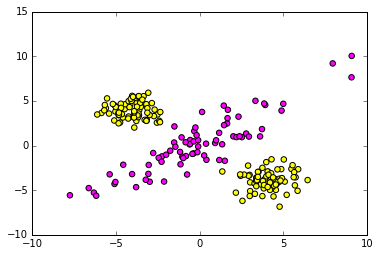

In [23]:
trainer = train_n_show(10)

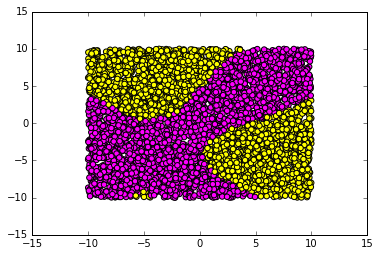

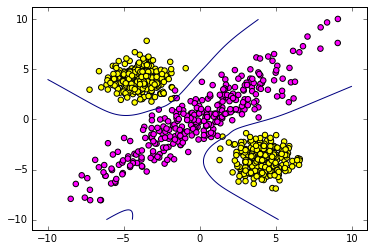

In [24]:
show_borders(trainer)

Training network with 50 hidden neurons
Percent of errors: 0.0


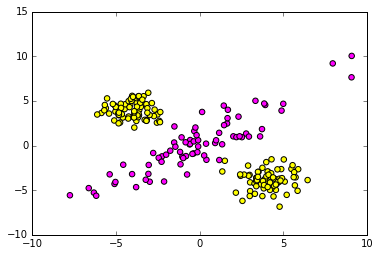

In [25]:
trainer = train_n_show(50)

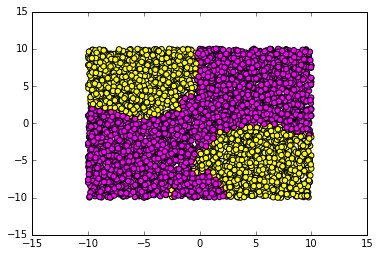

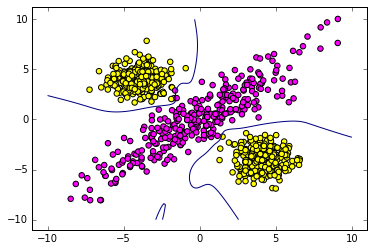

In [26]:
show_borders(trainer)

Видно, что при увеличении числа нейронов граница между классами становится сложнее, но это может привести к переобучению — на последних картинках видно, что в «жёлтый» класс записываются какие-то совсем не относящиеся к делу точки.